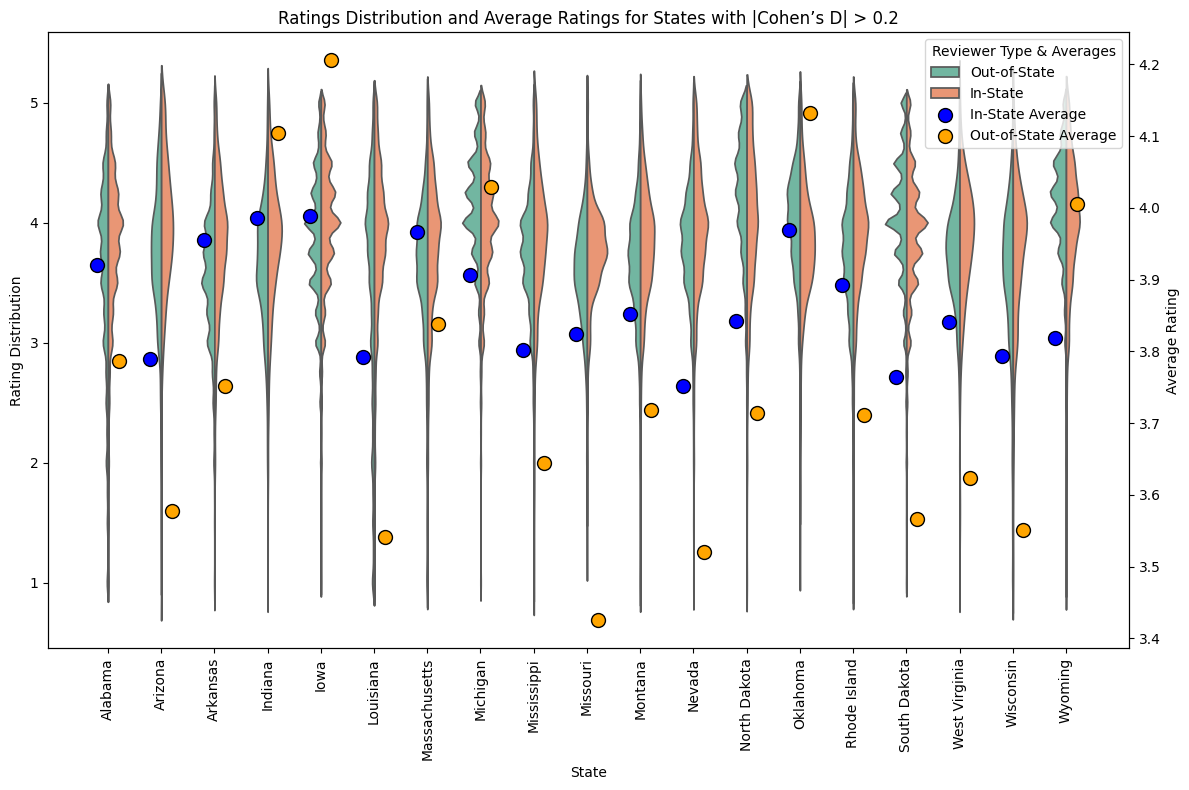

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math



US_ratings = pd.read_csv('USData/BA_US_states_all.csv')


def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

US_ratings['state_IN_VS_OUT'] = np.where(
    US_ratings['user_state'] == US_ratings['beer_state'], 
    'In-State', 
    'Out-of-State'
)

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Optional: sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()


significant_states = cohen_df_no_nan[
    (cohen_df_no_nan['Cohen_d'] > 0.2) | (cohen_df_no_nan['Cohen_d'] < -0.2)
].index
significant_states = sorted(significant_states)

filtered_ratings = US_ratings[US_ratings['beer_state'].isin(significant_states)]

average_ratings = filtered_ratings.groupby(['beer_state', 'state_IN_VS_OUT'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 8))

ax1 = sns.violinplot(
    x='beer_state', 
    y='rating', 
    hue='state_IN_VS_OUT', 
    data=filtered_ratings, 
    split=True, 
    inner=None, 
    palette='Set2'
)

ax1.legend_.remove()

ax1.set_xlabel('State')
ax1.set_ylabel('Rating Distribution')
ax1.set_title('Ratings Distribution and Average Ratings for States with |Cohen’s D| > 0.2')

ax2 = ax1.twinx()

colors = {'In-State': 'blue', 'Out-of-State': 'orange'}

labels_added = set()  

for i, state in enumerate(significant_states):
    state_avg_ratings = average_ratings[average_ratings['beer_state'] == state]
    
    for relation, color in colors.items():
        avg_value = state_avg_ratings[state_avg_ratings['state_IN_VS_OUT'] == relation]['rating']
        if not avg_value.empty:
            x_pos = i  # Position at the state's index
            offset = -0.2 if relation == 'In-State' else 0.2
            label = f'{relation} Average' if f'{relation} Average' not in labels_added else None
            
            ax2.scatter(x_pos + offset, avg_value, 
                        color=color, 
                        edgecolor='black', 
                        s=100, 
                        zorder=3, 
                        label=label)
            if label is not None:
                labels_added.add(label)

ax2.set_ylabel('Average Rating')

ax1.set_xticks(range(len(significant_states)))  
ax1.set_xticklabels(significant_states, rotation=90)  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines_combined, labels_combined = [], []
for l, la in zip(lines_1 + lines_2, labels_1 + labels_2):
    if la not in labels_combined:
        lines_combined.append(l)
        labels_combined.append(la)

ax1.legend(lines_combined, labels_combined, title='Reviewer Type & Averages', loc='upper right')

plt.tight_layout()



plt.savefig("modules/7.png")